In [ ]:
# pip! install PyPortfolioOpt

In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import warnings
warnings.filterwarnings('ignore')

In [2]:
#%% extract data
start_date = '2024-01-01'
split_date = '2024-06-30'
end_date = '2024-07-31'
tickers = ['AAPL','MSFT','NVDA','GOOG','AMZN','META','TSM','LLY','TSLA','AVGO']

train = yf.download(tickers, start=start_date, end=split_date)['Close']
test = yf.download(tickers, start=split_date, end=end_date)['Close']
test_ret = test.pct_change()

[*********************100%%**********************]  10 of 10 completed
[*********************100%%**********************]  10 of 10 completed


In [3]:
# calculate expected returns and covariance matrix
from pypfopt.expected_returns import mean_historical_return
from pypfopt.risk_models import CovarianceShrinkage

mu = mean_historical_return(train)
S = CovarianceShrinkage(train).ledoit_wolf()

In [4]:
# calculate weights of efficient portfolio
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import objective_functions

ef = EfficientFrontier(mu, S)
weights = ef.max_sharpe()
weights = ef.clean_weights()
print(weights)

OrderedDict([('AAPL', 0.0), ('AMZN', 0.0), ('AVGO', 0.0), ('GOOG', 0.04042), ('LLY', 0.19398), ('META', 0.0), ('MSFT', 0.0), ('NVDA', 0.76559), ('TSLA', 0.0), ('TSM', 0.0)])


In [5]:
# using these weights to indicate how many shares of each asset to buy, assuming portfolio of $1,000,000
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices

latest_prices = get_latest_prices(train)
da = DiscreteAllocation(weights, latest_prices, total_portfolio_value=1000000)
allocation, leftover = da.lp_portfolio()
print(allocation)

{'GOOG': 221, 'LLY': 214, 'NVDA': 6197}


In [6]:
def rough_weight_ret(data, weights):
    # Make a copy of the original data
    data_copy = data.copy()
    
    # calculate returns of test portfolio, using rough weights
    for ticker, weight in weights.items():
        if ticker in data_copy.columns:
            data_copy[ticker] = data_copy[ticker] * weight

    data_copy['returns'] = data_copy.sum(axis=1)
    
    # convert to log returns
    data_copy['returns'] = np.log( 1 + data_copy['returns'])

    # calculate returns over 1 year test period
    annual_ret = np.exp(data_copy['returns'].sum())-1
    print('------using rough weights------')
    print('Annual regular return: ',annual_ret)

    # calculate standard deviation over same period
    annual_std = (np.exp(data_copy['returns'])-1).std()
    print('Annual regular std: ', annual_std)

    # calculate sharpe ratio
    sr = annual_ret/ annual_std
    print("Sharpe Ratio is: ", sr)
    print('--------------------------------')
    
    data_copy[["returns"]].cumsum().plot()

In [7]:
def discrete_ret(data, allocation):
    # Make a copy of the original data
    data_copy = data.copy()
    
    # calculate allocation of test portfolio, using discrete allocation
    for column in data.columns:
        if column in allocation:
            data_copy[column] = data_copy[column]*allocation[column]
        else:
            data_copy[column] = data_copy[column]*0

    # calculate portfolio size
    data_copy['balance'] = data_copy.sum(axis=1)

    # calculate portfolio (log) returns
    data_copy['ret'] = np.log ( 1 + data_copy['balance'].pct_change())

    # calculate returns over 1 year test period
    annual_ret = np.exp(data_copy['ret'].sum())-1
    print('------using discrete allocation------')
    print('Annual regular return: ',annual_ret)

    # calculate standard deviation over same period
    annual_std = (np.exp(data_copy['ret'])-1).std()
    print('Annual regular std: ', annual_std)

    # calculate sharpe ratio
    sr = annual_ret/ annual_std
    print("Sharpe Ratio is: ", sr)
    print('--------------------------------')
    
    data_copy[["ret"]].cumsum().plot()

------using rough weights------
Annual regular return:  -0.05097337292195392
Annual regular std:  0.0258140331510372
Sharpe Ratio is:  -1.9746380824611989
--------------------------------
------using discrete allocation------
Annual regular return:  -0.0524255490637745
Annual regular std:  0.026887227070598717
Sharpe Ratio is:  -1.949831008088671
--------------------------------


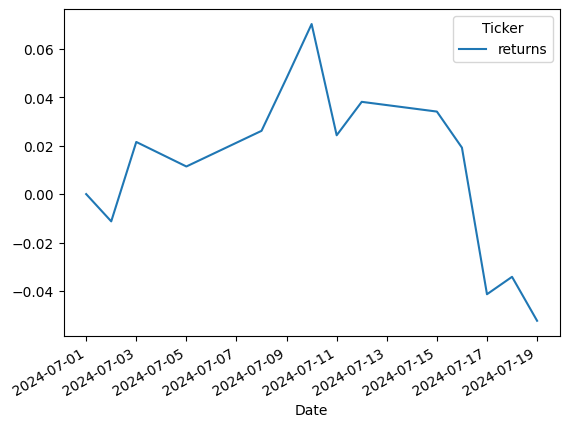

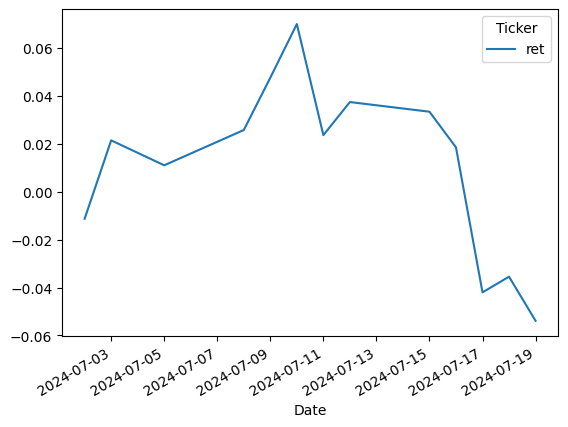

In [8]:
rough_weight_ret(test_ret, weights)
discrete_ret(test, allocation)